# 使用多元遥感数据的预测山体滑坡区域
- 使用U-Net算法

## 导入需要使用的包

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
"""h5py是用于处理大型数据集的包,
本次的遥感数据的存储格式为HDF5。*.h5"""
import h5py

## 数据集合介绍
- 本次使用到Landslide4Sense旨在提供高质量的、多源的遥感数据，用于训练和验证机器学习模型，这些模型能够识别并分析山体滑坡事件。这种类型的数据对于理解和预防由于滑坡引起的自然灾害非常重要。
- 我们使用数据集有：Sentinel-2多光谱数据、ALOS PALSAR遥感影像数据和人工标注的山体滑坡区域数据
- **Sentinel-2多光谱数据包含12个波段**
    - B1 - Coastal/Aerosol (443 nm): 海岸/气溶胶波段，用于监测空气中的颗粒物和海岸线变化。
    - **B2 - Blue (490 nm): 蓝光波段，有助于水体检测和植被分析。**
    - **B3 - Green (560 nm): 绿光波段，对植被健康和土地覆盖分类特别有用。**
    - **B4 - Red (665 nm): 红光波段，常用于植被指数计算，如NDVI（归一化差异植被指数）。**
    - B5 - Vegetation Red Edge (705 nm): 植被红边波段1，反映植被健康状况。
    - B6 - Vegetation Red Edge (740 nm): 植被红边波段2。
    - B7 - Vegetation Red Edge (783 nm): 植被红边波段3，这些红边波段对植被的生理状态和叶绿素含量敏感。
    - **B8 - NIR (842 nm): 近红外波段，用于评估植被覆盖和生物量。**
    - B9 - Water vapor (940 nm): 用于大气校正，监测水汽。
    - B10 - SWIR - Cirrus (1375 nm): 高空卷云波段，用于云检测和大气校正。
    - B11 - SWIR (1610 nm): 短波红外波段1，用于植被分类、水体检测和土壤/植被的湿度评估。
    - B12 - SWIR (2190 nm): 短波红外波段2，用于区分植被类型，检测植被的水分状态和岩石矿物。
- **ALOS PALSAR数据包含两个波段**
    - **B13 - Slope: 利用ALOS PALSAR雷达数据生成的坡度信息，显示地形的倾斜程度。坡度是山体滑坡分析中的一个重要因素，因为它直接影响地表的稳定性。**
    - **B14 - Digital Elevation Model (DEM): ALOS PALSAR数据生成的数字高程模型，提供地表的高程信息。高程数据对于理解地形变化、水文分析以及灾害风险评估至关重要。**


**这14个波段合成为一个HDF5（.h5）文件**，方便我们进行管理，数据集有含有image数据是遥感数据和label数据即是人工标注的山体滑坡的区域。


## 测试数据集
可视化我们的数据集，根据不同的波段我们可以尝试不同的遥感影像数据
- 卫星影像数据，通过B2,B3,B4来进行可视化
- NDVI数据可视化可以通过B8和B4计算得到

### 这里补充一下NDVI的计算公式
NDVI = (NIR - Red) / (NIR + Red)

In [2]:
# 导入文件路径
path_single = r"../data/landslide/TrainData/img/image_2000.h5"
path_single_mask = r"../data/landslide/TrainData/mask/mask_2000.h5"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ls ['img']
input data shape (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


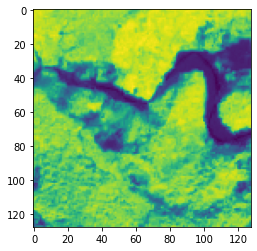

In [3]:
f_data = np.zeros((1,128,128,3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls",ls)
    data = np.array(hdf.get('img'))
    print("input data shape",data.shape)
    plt.imshow(data[:,:,3:0:-1])
    
    data_red = data[:,:,3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:,:,3:0:-1]
    data_ndvi = np.divide(data_nir-data_red,np.add(data_red,data_nir))#ndvi数据
    f_data[0,:,:,0] = data_ndvi
    f_data[0,:,:,1] = data[:, :, 12]#slope数据
    f_data[0,:,:,2] = data[:, :, 13]#slope数据
    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    plt.imshow(data_ndvi)
    
    
    
    

## 导入我们的训练数据集
通过上面的简单的可视化，我们可以得知我们的图片大小为128*128。
这里我们需要使用的波段是6个，其中：
- 遥感卫星影像对应：B2，B3，B4
- NDVI数据对应：B8
- Slope数据对应：B12
- DEM数据对应：B13

因此我们的训练集数据TRAIN_XX应该是(3799，128，128，6)，TRAIN_YY(3799,128,128,1)

In [4]:
#定义训练数据和标签路径
TRAIN_PATH = r"../data/landslide/TrainData/img/*.h5"
TRAIN_MASK = r'../data/landslide/TrainData/mask/*.h5'
#初始化存储的数组
TRAIN_XX = np.zeros((3799,128,128,6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
#获取所有训练图像和掩码文件的路径
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

## 构建训练数据集


In [5]:
#开始之前先检查一下是不是在GPU上进行训练的
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#实现数据的读取和遍历
for i,(img,mask) in enumerate(zip(all_train,all_mask)):
    print(i,img,mask)
    #处理图像数据
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        #避免数组中存在NaN的数值
        data[np.isnan(data)] = 0.000000001

        #归一化  将数据缩放到以最大值的一半为中心的一个新范围内，因为我们是要解决一个二分类的问题。
        mid_rgb = data[:,:,1:4].max()/2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI图像的计算
        data_red = data[:,:,3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # 处理后的数据填充到预先定义的数组TRAIN_XX
        TRAIN_XX[i, :, :, 0]= 1 - data[:, :, 3]/mid_rgb #RED
        TRAIN_XX[i, :, :, 1]= 1 - data[:, :, 2]/mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
    
    #读取并处理掩码数据，并将其保TRAIN_YY
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('mask'))
        TRAIN_YY[i,:,:,0] = data


0 ../data/landslide/TrainData/img\image_1.h5 ../data/landslide/TrainData/mask\mask_1.h5
1 ../data/landslide/TrainData/img\image_10.h5 ../data/landslide/TrainData/mask\mask_10.h5
2 ../data/landslide/TrainData/img\image_100.h5 ../data/landslide/TrainData/mask\mask_100.h5
3 ../data/landslide/TrainData/img\image_1000.h5 ../data/landslide/TrainData/mask\mask_1000.h5
4 ../data/landslide/TrainData/img\image_1001.h5 ../data/landslide/TrainData/mask\mask_1001.h5
5 ../data/landslide/TrainData/img\image_1002.h5 ../data/landslide/TrainData/mask\mask_1002.h5
6 ../data/landslide/TrainData/img\image_1003.h5 ../data/landslide/TrainData/mask\mask_1003.h5
7 ../data/landslide/TrainData/img\image_1004.h5 ../data/landslide/TrainData/mask\mask_1004.h5
8 ../data/landslide/TrainData/img\image_1005.h5 ../data/landslide/TrainData/mask\mask_1005.h5
9 ../data/landslide/TrainData/img\image_1006.h5 ../data/landslide/TrainData/mask\mask_1006.h5
10 ../data/landslide/TrainData/img\image_1007.h5 ../data/landslide/Train

<ipython-input-6-47f258a8589e>:27: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE


1670 ../data/landslide/TrainData/img\image_2501.h5 ../data/landslide/TrainData/mask\mask_2501.h5
1671 ../data/landslide/TrainData/img\image_2502.h5 ../data/landslide/TrainData/mask\mask_2502.h5
1672 ../data/landslide/TrainData/img\image_2503.h5 ../data/landslide/TrainData/mask\mask_2503.h5
1673 ../data/landslide/TrainData/img\image_2504.h5 ../data/landslide/TrainData/mask\mask_2504.h5
1674 ../data/landslide/TrainData/img\image_2505.h5 ../data/landslide/TrainData/mask\mask_2505.h5
1675 ../data/landslide/TrainData/img\image_2506.h5 ../data/landslide/TrainData/mask\mask_2506.h5
1676 ../data/landslide/TrainData/img\image_2507.h5 ../data/landslide/TrainData/mask\mask_2507.h5
1677 ../data/landslide/TrainData/img\image_2508.h5 ../data/landslide/TrainData/mask\mask_2508.h5
1678 ../data/landslide/TrainData/img\image_2509.h5 ../data/landslide/TrainData/mask\mask_2509.h5
1679 ../data/landslide/TrainData/img\image_251.h5 ../data/landslide/TrainData/mask\mask_251.h5
1680 ../data/landslide/TrainData

<ipython-input-6-47f258a8589e>:20: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))



2267 ../data/landslide/TrainData/img\image_3039.h5 ../data/landslide/TrainData/mask\mask_3039.h5
2268 ../data/landslide/TrainData/img\image_304.h5 ../data/landslide/TrainData/mask\mask_304.h5
2269 ../data/landslide/TrainData/img\image_3040.h5 ../data/landslide/TrainData/mask\mask_3040.h5
2270 ../data/landslide/TrainData/img\image_3041.h5 ../data/landslide/TrainData/mask\mask_3041.h5
2271 ../data/landslide/TrainData/img\image_3042.h5 ../data/landslide/TrainData/mask\mask_3042.h5
2272 ../data/landslide/TrainData/img\image_3043.h5 ../data/landslide/TrainData/mask\mask_3043.h5
2273 ../data/landslide/TrainData/img\image_3044.h5 ../data/landslide/TrainData/mask\mask_3044.h5
2274 ../data/landslide/TrainData/img\image_3045.h5 ../data/landslide/TrainData/mask\mask_3045.h5
2275 ../data/landslide/TrainData/img\image_3046.h5 ../data/landslide/TrainData/mask\mask_3046.h5
2276 ../data/landslide/TrainData/img\image_3047.h5 ../data/landslide/TrainData/mask\mask_3047.h5
2277 ../data/landslide/TrainDat

## 查看我们处理好的数据

In [7]:
# 常规我们会使用的归一化方法
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


## 可视化数据

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


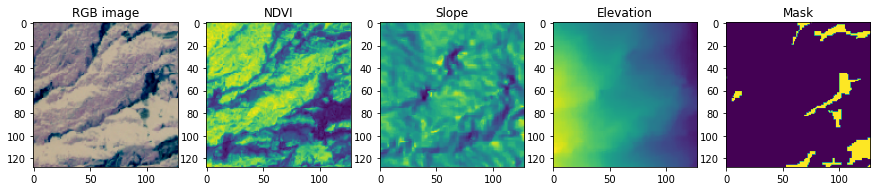

In [8]:
img=234
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

## 拆分测试集和训练集

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


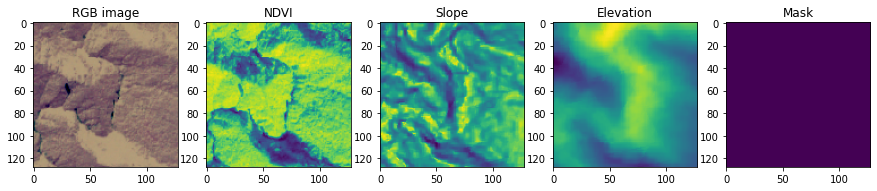

In [10]:
#随便一个数据进行可视化
img=155
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

In [11]:
#查看一下数据长度
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

In [12]:
#把前面的数据删掉，以便释放内存
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask 

In [13]:
# 导入评估指标
from utils1 import recall_m, precision_m, f1_m

## U-Net模型
<img src="../data/image/u-net.jpg" width="900" height="600">

In [14]:
import tensorflow as tf

# 定义U-Net模型
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    # 输入层
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # 编码器（收缩路径）
    # 第一层
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    # 第二层
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    # 第三层
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    # 第四层
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # 最底层
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

    # 解码器（扩展路径）
    # 第一层
    upConv6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    upConv6 = tf.keras.layers.concatenate([upConv6, conv4])
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upConv6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    # 第二层
    upConv7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upConv7 = tf.keras.layers.concatenate([upConv7, conv3])
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upConv7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    # 第三层
    upConv8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    upConv8 = tf.keras.layers.concatenate([upConv8, conv2])
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upConv8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    # 第四层
    upConv9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    upConv9 = tf.keras.layers.concatenate([upConv9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upConv9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    # 输出层
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # 创建模型
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    # 编译模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

In [15]:
#构建模型
model = unet_model(128, 128, 6)

# model.summary()
#模型检查点回调设置
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
# 早停回调设置，如果`val_loss`在10个epoch内没有降低，则停止训练
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]

#训练模型
history = model.fit(x_train, y_train, batch_size=16,  
          epochs=50, 
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

#报错模型

model.save("model_save.h5")

Epoch 1/50

Epoch 1: val_f1_m improved from -inf to 0.58223, saving model to best_model.h5
190/190 - 21s - loss: 0.0731 - accuracy: 0.9724 - f1_m: 0.2456 - precision_m: 0.5498 - recall_m: 0.2152 - val_loss: 0.0496 - val_accuracy: 0.9802 - val_f1_m: 0.5822 - val_precision_m: 0.6179 - val_recall_m: 0.5847 - 21s/epoch - 112ms/step
Epoch 2/50

Epoch 2: val_f1_m improved from 0.58223 to 0.60659, saving model to best_model.h5
190/190 - 8s - loss: 0.0440 - accuracy: 0.9836 - f1_m: 0.5687 - precision_m: 0.6948 - recall_m: 0.5077 - val_loss: 0.0474 - val_accuracy: 0.9813 - val_f1_m: 0.6066 - val_precision_m: 0.6665 - val_recall_m: 0.5861 - 8s/epoch - 43ms/step
Epoch 3/50

Epoch 3: val_f1_m improved from 0.60659 to 0.63544, saving model to best_model.h5
190/190 - 8s - loss: 0.0399 - accuracy: 0.9849 - f1_m: 0.5925 - precision_m: 0.7357 - recall_m: 0.5222 - val_loss: 0.0388 - val_accuracy: 0.9856 - val_f1_m: 0.6354 - val_precision_m: 0.7583 - val_recall_m: 0.5550 - 8s/epoch - 42ms/step
Epoch 4/50

In [38]:
#打印模型性能的输出
loss,accuracy,f1_score,precision,recall  = model.evaluate(x_valid,y_valid,verbose=0)
print(loss,accuracy,f1_score,precision,recall)

0.034138478338718414 0.9872847199440002 0.6817482113838196 0.8399496674537659 0.5770512223243713


# 可视化训练过程指标

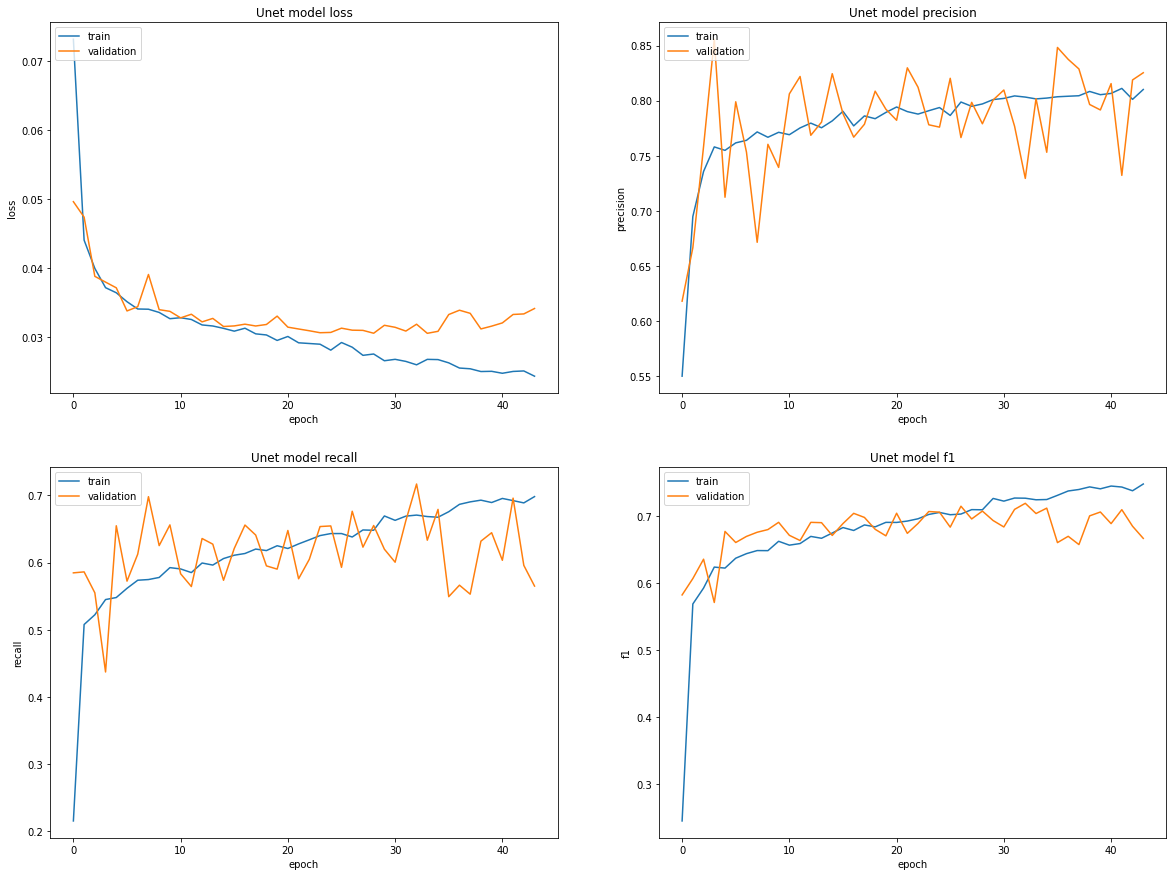

In [42]:
# 首先，使用`subplots`函数创建一个2x2的图表格区域，每个子图用于展示不同的性能指标。
# `figsize=(20,15)`指定了整个图表区域的大小。
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))

# 第一个子图(ax11)用于展示训练过程中的损失。
# `history.history['loss']`是训练损失的历史值，`history.history['val_loss']`是验证损失的历史值。
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.set_title("Unet model loss")
ax11.set_ylabel("loss")
ax11.set_xlabel("epoch")
ax11.legend(['train','validation'],loc='upper left')


# 第二个子图(ax12)用于展示训练过程中的精确度。
# 与损失绘图类似，这里使用`precision_m`（训练精度）和`val_precision_m`（验证精度）的历史值。
ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')


# 第三个子图(ax13)用于展示训练过程中的召回率。
# 使用`recall_m`（训练召回率）和`val_recall_m`（验证召回率）的历史值。
ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

# 第四个子图(ax14)用于展示训练过程中的F1得分。
# 使用`f1_m`（训练F1得分）和`val_f1_m`（验证F1得分）的历史值。

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

### 使用测试集进行一个简单的预测

In [43]:
#设置阈值
threshold = 0.5
#预测图像
pred_img = model.predict(x_valid)
#应用阈值并二值化
pred_img = (pred_img>threshold).astype(np.uint0)

24/24 [==============================] - 1s 36ms/step


<ipython-input-43-70d30b1eee10>:6: DeprecationWarning: `np.uint0` is a deprecated alias for `np.uintp`.  (Deprecated NumPy 1.24)
  pred_img = (pred_img>threshold).astype(np.uint0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

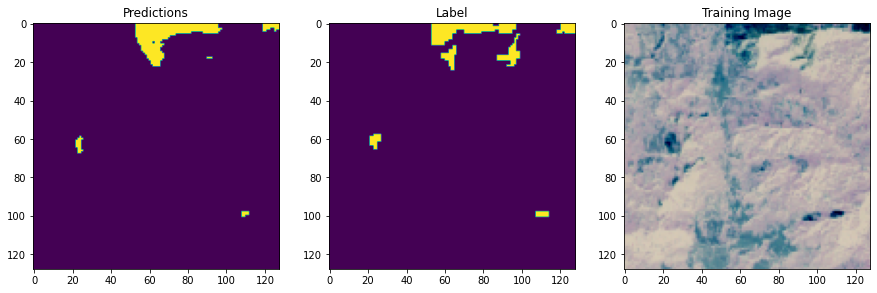

In [44]:
#可视化结果
img = 188
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

# 使用模型，生成验证数据

In [45]:
validation_url = r'../data/landslide/ValidData/img/*.h5'
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
#实现数据的读取和遍历
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        #避免数组中存在NaN的数值
        data[np.isnan(data)] = 0.000001

        # 归一化  
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI图像的计算
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # NDVI图像的计算
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

0 ../data/landslide/ValidData/img\image_1.h5
1 ../data/landslide/ValidData/img\image_10.h5
2 ../data/landslide/ValidData/img\image_100.h5
3 ../data/landslide/ValidData/img\image_101.h5
4 ../data/landslide/ValidData/img\image_102.h5
5 ../data/landslide/ValidData/img\image_103.h5
6 ../data/landslide/ValidData/img\image_104.h5
7 ../data/landslide/ValidData/img\image_105.h5
8 ../data/landslide/ValidData/img\image_106.h5
9 ../data/landslide/ValidData/img\image_107.h5
10 ../data/landslide/ValidData/img\image_108.h5
11 ../data/landslide/ValidData/img\image_109.h5
12 ../data/landslide/ValidData/img\image_11.h5
13 ../data/landslide/ValidData/img\image_110.h5
14 ../data/landslide/ValidData/img\image_111.h5
15 ../data/landslide/ValidData/img\image_112.h5
16 ../data/landslide/ValidData/img\image_113.h5
17 ../data/landslide/ValidData/img\image_114.h5
18 ../data/landslide/ValidData/img\image_115.h5
19 ../data/landslide/ValidData/img\image_116.h5
20 ../data/landslide/ValidData/img\image_117.h5
21 ../

<ipython-input-45-87ece6e89412>:25: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


 ../data/landslide/ValidData/img\image_4.h5
180 ../data/landslide/ValidData/img\image_40.h5
181 ../data/landslide/ValidData/img\image_41.h5
182 ../data/landslide/ValidData/img\image_42.h5
183 ../data/landslide/ValidData/img\image_43.h5
184 ../data/landslide/ValidData/img\image_44.h5
185 ../data/landslide/ValidData/img\image_45.h5
186 ../data/landslide/ValidData/img\image_46.h5
187 ../data/landslide/ValidData/img\image_47.h5
188 ../data/landslide/ValidData/img\image_48.h5
189 ../data/landslide/ValidData/img\image_49.h5
190 ../data/landslide/ValidData/img\image_5.h5
191 ../data/landslide/ValidData/img\image_50.h5
192 ../data/landslide/ValidData/img\image_51.h5
193 ../data/landslide/ValidData/img\image_52.h5
194 ../data/landslide/ValidData/img\image_53.h5
195 ../data/landslide/ValidData/img\image_54.h5
196 ../data/landslide/ValidData/img\image_55.h5
197 ../data/landslide/ValidData/img\image_56.h5
198 ../data/landslide/ValidData/img\image_57.h5
199 ../data/landslide/ValidData/img\image_58.

## 预测验证集数据集

In [46]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 [==============================] - 0s 35ms/step


(245, 128, 128, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

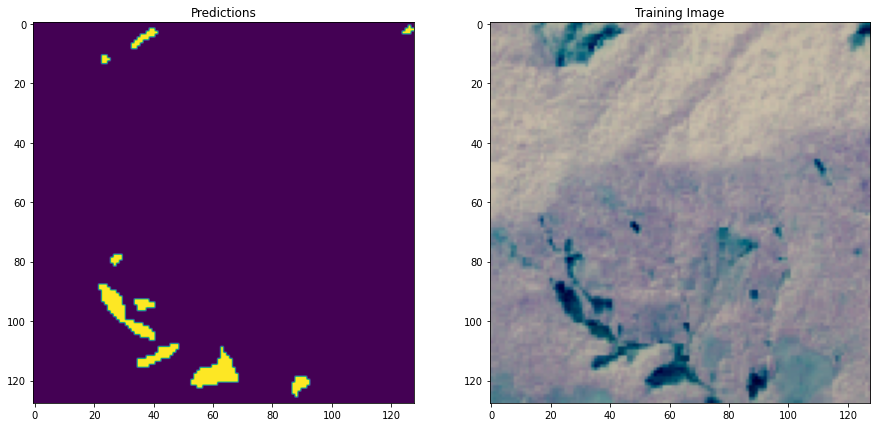

In [47]:
img = 167
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')

In [48]:
# 更新为新的相对路径
write_directory = r'../data/landslide/ValidData/mask'
import os

# 检查目录是否存在，如果不存在，则创建
# if not os.path.exists(write_directory):
#     os.makedirs(write_directory)
    
for i,name in enumerate(mask_name):
    h5f = h5py.File(write_directory+"/"+name,'w')
    #获取预测label
    pred_mask = pred_img[i,:,:,0]
    
    #讲label写入文件
    h5f.create_dataset('mask',data=pred_mask)
    
    #关闭文件
    h5f.close()
